<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

This notebook puts together tutorials available at the [Gravitational-Wave Open Science Center (GWOSC) website](https://www.gw-openscience.org)

Topics:

* Plotting and manipulating publicly available gravitational-wave posterior samples. 
* Carrying out parameter estimation on open gravitational-wave data.

One of the modules we will be using in this notebook is [Bilby](https://lscsoft.docs.ligo.org/bilby/).  Bilby is a user-friendly Bayesian inference library primarily designed for inference of compact binary coalescence events in interferometric data.

# Part 3.1:  Parameter estimation for compact object mergers -- Using and interpreting posterior samples

This is a simple demonstration on loading and viewing public Bayesian inference results pertaining to gravitational-wave signals.

The data used here is downloaded from the public DCC page [LIGO-P1800370](https://dcc.ligo.org/LIGO-P1800370/public).

## Installation

To deal with time series we use [GWPy](https://gwpy.github.io)'s `TimeSeries`.

To generate waveforms to compare to the data, we need [LALSuite](https://lscsoft.docs.ligo.org/lalsuite/).

In [1]:
# -- Use the following line for google colab
! pip install -q 'dynesty==1.1'
! pip install -q 'corner==2.0.1' 'astropy==4.0.3'
! pip install -q 'lalsuite==6.82' 'bilby==1.0.4' 'gwpy==2.0.2'

     |████████████████████████████████| 87 kB 4.5 MB/s 
     |████████████████████████████████| 10.3 MB 701 kB/s 
     |████████████████████████████████| 27.3 MB 174 kB/s 
     |████████████████████████████████| 11.6 MB 705 kB/s 
     |████████████████████████████████| 1.4 MB 53.8 MB/s 
     |████████████████████████████████| 51 kB 7.2 MB/s 
     |████████████████████████████████| 1.4 MB 49.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 46 kB 4.3 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 4.0 MB 48.6 MB/s 
     |████████████████████████████████| 57 kB 5.7 MB/s 
     |████████████████████████████████| 299 kB 61.9 MB/s 


**Important**: With Google Colab, you may need to restart the runtime after running the cell above.

## Initialization

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import corner
import bilby
import dynesty

We check the Bilby and dynesty versions

In [3]:
print(bilby.__version__)
print(dynesty.__version__)

1.0.4: release
1.1


## Get the data

Select the GW150914 event.

In [5]:
label = 'GW150914'
filename = label+'_GWTC-1.hdf5'

# If you do not have wget installed, simply manually
# download with your brower the data file available at
# https://dcc.ligo.org/LIGO-P1800370/public/GW150914_GWTC-1.hdf5 
! wget https://dcc.ligo.org/LIGO-P1800370/public/{filename}

--2022-12-20 07:15:02--  https://dcc.ligo.org/LIGO-P1800370/public/GW150914_GWTC-1.hdf5
Resolving dcc.ligo.org (dcc.ligo.org)... 131.215.125.144
Connecting to dcc.ligo.org (dcc.ligo.org)|131.215.125.144|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5 [following]
--2022-12-20 07:15:03--  https://dcc.ligo.org/public/0157/P1800370/005/GW150914_GWTC-1.hdf5
Reusing existing connection to dcc.ligo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 7026464 (6.7M)
Saving to: ‘GW150914_GWTC-1.hdf5.1’

GW150914_GWTC-1.hdf 100%[===================>]   6.70M  3.06MB/s    in 2.2s    

2022-12-20 07:15:05 (3.06 MB/s) - ‘GW150914_GWTC-1.hdf5.1’ saved [7026464/7026464]



This file contains the posterior distrubtions resulting from Bayesian inference analysese performed on data relative to the event GW150914.
We create an object for the data file in question.

In [6]:
posterior = h5py.File('./'+filename, 'r')

### Looking into the file structure

[Hdf5](https://www.hdfgroup.org/solutions/hdf5/) (hierarchical data format) files work a bit like dictionaries.

In [7]:
print('This file contains four datasets: ', posterior.keys())

This file contains four datasets:  <KeysViewHDF5 ['IMRPhenomPv2_posterior', 'Overall_posterior', 'SEOBNRv3_posterior', 'prior']>


This data file contains several datasets.
* Two datasets use separate models (approximants) for the gravitational waveform, namely `IMRPhenomPv2` and `SEOBNRv3`.  [See the [paper](https://dcc.ligo.org/LIGO-P1800307) for more details.]
* There is a joint dataset that combines equal numbers of samples from each individual model (`Overall_posterior`).
* Finally, there is a dataset containing samples drawn from the prior used for the analyses (`prior`).

Let's inspect what one of the posterior entries includes.

In [8]:
print(posterior['Overall_posterior'].dtype.names)

('costheta_jn', 'luminosity_distance_Mpc', 'right_ascension', 'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun', 'spin1', 'spin2', 'costilt1', 'costilt2')


Here are some brief descriptions of these parameters and their uses:

| Key | Meaning | Units |
| :- | :-- | :-- |
| `luminosity_distance_Mpc` | Luminosity distance | Mpc |
| `m1_detector_frame_Msun` | Primary (larger) black hole mass (measesured at the detector) | Solar masses |
| `m2_detector_frame_Msun` | Secondary (smaller) black hole mass (measesured at the detector) | Solar masses |
| `right_ascension` | Right ascension of the sky location of the soure | rad |
| `declination` | Declination of the sky location of the soure mode | rad |
| `costheta_jn` | Cosine of the angle between line of sight and total angular momentum vector of the source | rad |
| `spin1` | Primary black hole spin magnitude and cosine of the zenith angle between the spin and the orbital angular momentum vector of the source | dimensionless |
| `costilt1` | Cosine of the zenith angle between the primary black hole spin and the orbital angular momentum vector of the source | dimensionless |
| `spin2` | Secondary black hole spin magnitude and cosine of the zenith angle between the spin and the orbital angular momentum vector of the source | dimensionless |
| `costilt2` | Cosine of the zenith angle between the scedondary black hole spin and the orbital angular momentum vector of the source | dimensionless |


A convenient and elegant way to load up an array of samples is to feed it as a NumPy array to [pandas](https://pandas.pydata.org/):

In [9]:
samples = pd.DataFrame.from_records(np.array(posterior['Overall_posterior']))

In [10]:
samples

,costheta_jn,luminosity_distance_Mpc,right_ascension,declination,m1_detector_frame_Msun,m2_detector_frame_Msun,spin1,spin2,costilt1,costilt2
0,-0.976633,517.176717,1.456176,-1.257815,39.037380,37.044563,0.417147,0.867740,-0.280624,0.403853
1,-0.700404,401.626864,2.658802,-0.874661,34.620096,34.184416,0.125709,0.260679,-0.757349,-0.312285
2,-0.840752,369.579071,1.106548,-1.136396,37.894343,33.970520,0.581047,0.926893,0.649781,-0.510843
3,-0.583657,386.935268,2.077180,-1.246351,36.412973,35.684463,0.235808,0.094391,0.116578,-0.720505
4,-0.928271,345.104345,0.993604,-1.069243,39.477251,31.645008,0.511521,0.868009,-0.438237,0.269333
...,...,...,...,...,...,...,...,...,...,...
8345,-0.691637,306.985025,1.485646,-1.269228,37.561962,33.355792,0.484003,0.627191,0.194507,-0.408345
8346,-0.834615,462.649414,2.065362,-1.265618,37.824298,36.674075,0.589654,0.650758,-0.737792,0.875384
8347,-0.911463,448.930876,1.536913,-1.257956,38.063291,35.757913,0.708407,0.714805,0.852085,-0.797475
8348,-0.856914,561.020036,2.367289,-1.211824,44.884396,31.592433,0.389284,0.521304,-0.251461,0.830526


These are all the samples stored in the `Overall` dataset. 

## Plotting

We can plot all of them with, for instance, the usual [corner](https://corner.readthedocs.io/en/latest/) package:

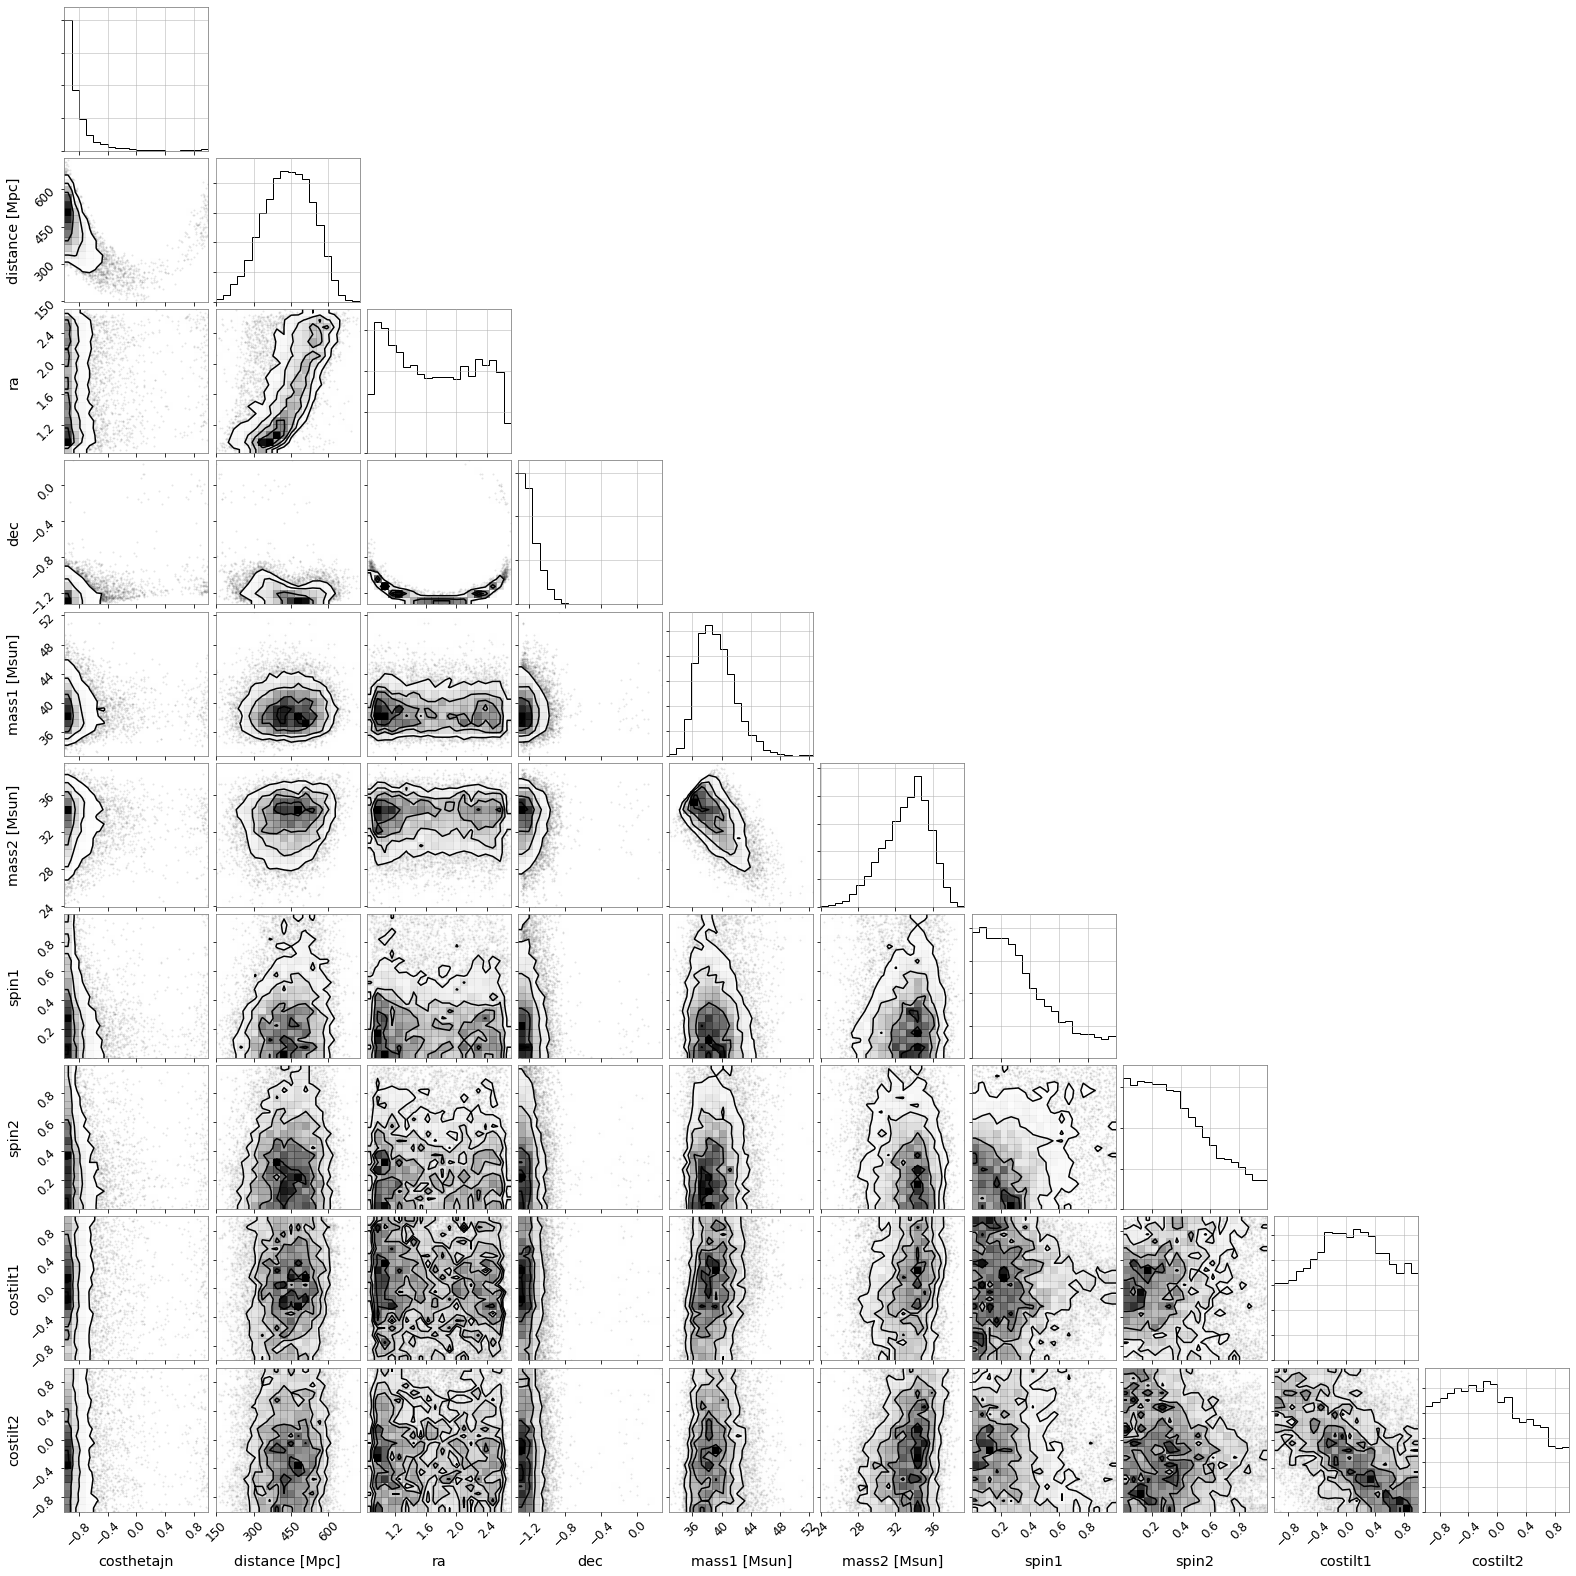

In [11]:
corner.corner(samples,labels=['costhetajn',
                              'distance [Mpc]',
                              'ra',
                              'dec',
                              'mass1 [Msun]',
                              'mass2 [Msun]',
                              'spin1',
                              'spin2',
                              'costilt1',
                              'costilt2']);

We can manualy select one parameter and plot the marginalised distributions from the four distinct data sets.  We do this for the `luminosity distance`:

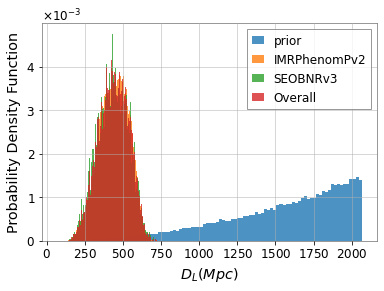

In [12]:
for label in ['prior', 'IMRPhenomPv2_posterior', 'SEOBNRv3_posterior', 'Overall_posterior']:
    plt.hist(posterior[label]['luminosity_distance_Mpc'], bins = 100, label=label.replace('_posterior',''), alpha=0.8, density=True)

plt.xlabel(r'$D_L (Mpc)$')
plt.ylabel('Probability Density Function')
plt.legend()
plt.show()

### Computing new quantities

The masses given are the ones measured at the detector, i.e., in the *detector frame*. To determine the actual (*source frame*) masses of the source black holes, we need to correct for the cosmological redshift of the gravitational wave. This forces us to assume a cosmology.

And, of course, we can inform Python about cosmology 😀

In [13]:
import astropy.units as u
from astropy.cosmology import Planck15, z_at_value

We compute the redshift value for all the samples (using only their distance value). See [astropy.cosmology](http://docs.astropy.org/en/stable/api/astropy.cosmology.z_at_value.html) for implementation details, in particular how to make the following more efficient:

In [14]:
z = np.array([z_at_value(Planck15.luminosity_distance, dist * u.Mpc)
              for dist in samples['luminosity_distance_Mpc']])

We add new entries to `samples`.

In [15]:
print(samples.keys())
print(samples.shape)

Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'spin1', 'spin2', 'costilt1', 'costilt2'],
      dtype='object')
(8350, 10)


In [16]:
samples['redshift'] = z
samples['m1_source_frame_Msun'] = samples['m1_detector_frame_Msun']/(1.0+samples['redshift'])
samples['m2_source_frame_Msun'] = samples['m2_detector_frame_Msun']/(1.0+samples['redshift'])

In [17]:
print(samples.keys())
print(samples.shape)

Index(['costheta_jn', 'luminosity_distance_Mpc', 'right_ascension',
       'declination', 'm1_detector_frame_Msun', 'm2_detector_frame_Msun',
       'spin1', 'spin2', 'costilt1', 'costilt2', 'redshift',
       'm1_source_frame_Msun', 'm2_source_frame_Msun'],
      dtype='object')
(8350, 13)


We can plot the marginalised probability density functions for the 3 newly defined quantities:

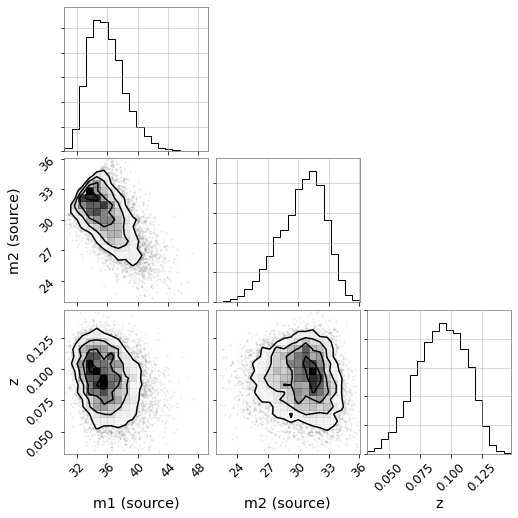

In [18]:
corner.corner(samples[['m1_source_frame_Msun',
                       'm2_source_frame_Msun',
                       'redshift']],
              labels=['m1 (source)',
                      'm2 (source)',
                      'z']);

## Calculating credible intervals
Let's see how we can use the [Bilby package](https://lscsoft.docs.ligo.org/bilby/) to calcuate summary statistics for the posterior, e.g., the median and 90% credible interval.

The [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass) is an important quantity in gravitational-wave physics.  It is the main driver of the gravitational-wave phase when the source is a two body system.  Its definition is

$$
\mathcal{M} = \frac{(m_1m_2)^{3/5}}{(m_1+m_2)^{1/5}}
$$

In [19]:
# Calculate the detector frame chirp mass
mchirp = ((samples['m1_detector_frame_Msun'] * samples['m2_detector_frame_Msun'])**(0.6))/\
         (samples['m1_detector_frame_Msun'] + samples['m2_detector_frame_Msun'])**(0.2)

# Initialize a SampleSummary object to describe the chirp mass posterior samples
chirp_mass_samples_summary = bilby.core.utils.SamplesSummary(samples=mchirp, average='median')

# Output the desired information
print('Median chirp mass: {:.1f} Msun'.format(chirp_mass_samples_summary.median))
print('90% credible interval for the chirp mass: [{:.1f}, {:.1f}] Msun'.format(chirp_mass_samples_summary.lower_absolute_credible_interval,
                                                                        chirp_mass_samples_summary.upper_absolute_credible_interval))

Median chirp mass: 31.2 Msun
90% credible interval for the chirp mass: [29.7, 33.0] Msun


# Part 3.2: Parameter estimation on GW150914 using open data

This part of the notebook estimates the non-spinning parameters of the binary black hole system using commonly used prior distributions.
   
Find more examples at https://lscsoft.docs.ligo.org/bilby/examples.html

## Initialization

We begin by importing some commonly used classes and methods.

In [20]:
from bilby.core.prior import Uniform
from bilby.gw.conversion import convert_to_lal_binary_black_hole_parameters, generate_all_bbh_parameters

from gwpy.timeseries import TimeSeries

### Set up empty interferometers

We will be using data from the Hanford (H1) and Livinston (L1) ground-based gravitational wave detectors. To start, we create two "empty" interferometer objects. These are empty in the sense that they do not have any strain data. But, they know about the orientation and location of their respective namesakes. It may also be interesting to note that they are initialised with the planned design sensitivity power spectral density of advanced LIGO, which we will overwrite later on.

In [21]:
H1 = bilby.gw.detector.get_empty_interferometer("H1")
L1 = bilby.gw.detector.get_empty_interferometer("L1")

## Getting the data: GW150914

Once more, we pick GW150914 to demonstrate things.

Our first task is to obtain the relevant data.  To do so, we need to know the trigger time: we already know how to do this with `gwosc`.  [Alternatively we can look it up manually on the [GWOSC page](https://www.gw-openscience.org/events/GW150914/).]

In [22]:
# -- Uncomment following line if running in Google Colab
! pip install gwosc #-q 'gwosc==0.5.4'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
from gwosc.datasets import event_gps
time_of_event = event_gps('GW150914')
print(time_of_event)

1126259462.4


We use [GWPy](https://gwpy.github.io/) to download the open strain data.

To analyse GW150914, we will use a 4s period duration centered on the event itself. It is standard to choose the data such that it always includes a "post trigger duration" of 2s, that is, there are always 2s of data after the trigger time. We therefore define all times relative to the trigger time, the duration and this 2s post-trigger duration.

In [24]:
# Definite times in relation to the trigger time (time_of_event), duration and post_trigger_duration
post_trigger_duration = 2 # s
duration = 4 # s
analysis_start = time_of_event + post_trigger_duration - duration
analysis_end = analysis_start + duration

# Fetch the open data
H1_analysis_data = TimeSeries.fetch_open_data(
    "H1", analysis_start, analysis_end, sample_rate=4096, cache=True)

L1_analysis_data = TimeSeries.fetch_open_data(
    "L1", analysis_start, analysis_end, sample_rate=4096, cache=True)

Here, `H1_analysis_data` and its L1 counterpart are GWPy `TimeSeries` objects. Remember that as such we can readily plot the data itself:

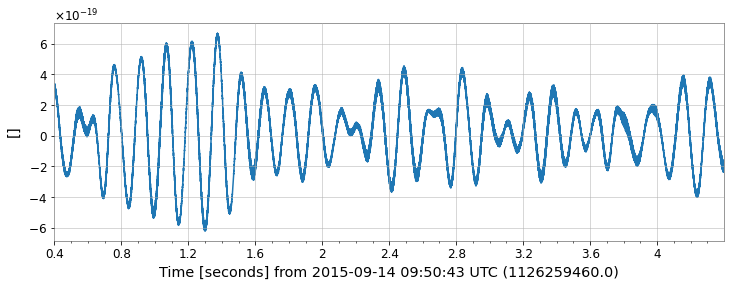

In [25]:
H1_analysis_data.plot()
plt.show()

## Initialise the Bilby interferometers with the strain data

Now, we pass the downloaded strain data to our `H1` and `L1` Bilby interferometer objects. For other methods to set the strain data, see the various `set_strain_data*` methods.

In [26]:
H1.set_strain_data_from_gwpy_timeseries(H1_analysis_data)
L1.set_strain_data_from_gwpy_timeseries(L1_analysis_data)

### Download the power spectral data

Parameter estimation relies on having a power spectral density (PSD) - an estimate of the coloured noise properties of the data. Here, we will create a PSD using off-source data, that is, data that does not contain the stretch of time we wish to analyze. For a review of methods to estimate PSDs, see, e.g. [Chatziioannou et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019PhRvD.100j4004C/abstract).

Again, we need to download this additional data from the open strain data. We start by figuring out the amount of data needed. In this case: 32 times the analysis duration. We fetch the segment with this duration immediately preceding the analysis segment. We do this once per detector and store the data in a `gwpy` `TimeSeries` object.

In [27]:
psd_duration = duration * 32
psd_start_time = analysis_start - psd_duration
psd_end_time = psd_start_time + psd_duration

H1_psd_data = TimeSeries.fetch_open_data(
    "H1", psd_start_time, psd_end_time, sample_rate=4096, cache=True)

L1_psd_data = TimeSeries.fetch_open_data(
    "L1", psd_start_time, psd_end_time, sample_rate=4096, cache=True)

Having obtained the data to generate the PSD, we now use the standard [gwpy psd](https://gwpy.github.io/docs/stable/api/gwpy.timeseries.TimeSeries.html#gwpy.timeseries.TimeSeries.psd) method to calculate the PSD. Here, the `psd_alpha` variable is converting the `roll_off` (in seconds of the Tukey window) applied to the strain data into the fractional value used by `gwpy` (again for the Tukey window). This applies a window with an appropriate shape to the time-domain data.  `overlap` denotes how many seconds of overlap there should be between consecutive segments over which the median is calculated.  With `overlap = 0` (seconds), a `fftlength = duration = 4` (seconds), and `psd_duration = duration * 32`, the median will be evaluated over 8 consecutive segments each lasting 4 seconds.

In [28]:
psd_alpha = 2 * H1.strain_data.roll_off / duration
H1_psd = H1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")
L1_psd = L1_psd_data.psd(fftlength=duration, overlap=0, window=("tukey", psd_alpha), method="median")

### Initialise the PSD
Now that we have PSDs for H1 and L1, we can overwrite the `power_spectal_density` attribute of our interferometers with a new PSD.  This is where we overwrite the design sensitivity PSDs given to the detectors by default upon creating them.

In [29]:
H1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=H1_psd.frequencies.value, psd_array=H1_psd.value)
L1.power_spectral_density = bilby.gw.detector.PowerSpectralDensity(
    frequency_array=L1_psd.frequencies.value, psd_array=L1_psd.value)

### Looking at the data
After spending a bit of time now downloading and initializing things, we check that everything makes sense. To do this, we plot our analysis data alongside the amplitude spectral density (ASD); this is just the square root of the PSD and has the right units to be comparable to the frequency-domain strain data.

08:20 bilby INFO    : Generating frequency domain strain from given time domain strain.
08:20 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


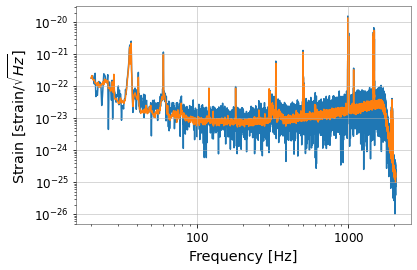

In [30]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we will use in the analysis
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

08:21 bilby INFO    : Generating frequency domain strain from given time domain strain.
08:21 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


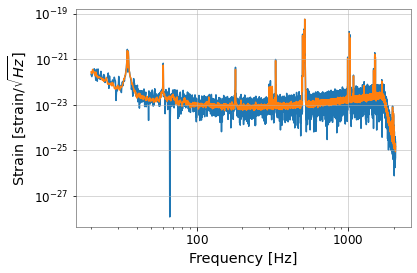

In [31]:
fig, ax = plt.subplots()
idxs = L1.strain_data.frequency_mask  # This is a boolean mask of the frequencies which we will use in the analysis
ax.loglog(L1.strain_data.frequency_array[idxs],
          np.abs(L1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(L1.power_spectral_density.frequency_array[idxs],
          L1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

What is happening at high frequencies? This is an artifact of the downsampling applied to the data.  Note that we downloaded the 4096Hz data which is downsampled from 16384Hz. We are not really interested in the data at these high frequencies so let's adjust the maximum frequency used in the analysis to 1024 Hz and plot things again.

In [32]:
H1.maximum_frequency = 1024 # Hz
L1.maximum_frequency = 1024 # Hz

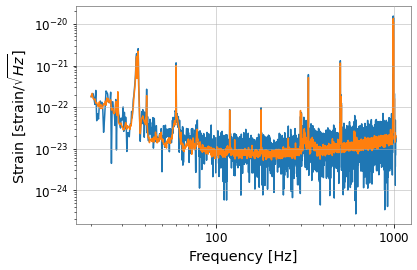

In [33]:
fig, ax = plt.subplots()
idxs = H1.strain_data.frequency_mask
ax.loglog(H1.strain_data.frequency_array[idxs],
          np.abs(H1.strain_data.frequency_domain_strain[idxs]))
ax.loglog(H1.power_spectral_density.frequency_array[idxs],
          H1.power_spectral_density.asd_array[idxs])
ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Strain [strain/$\sqrt{Hz}$]")
plt.show()

That is better! We will not analyse any data near the artifact produced by downsampling.

Now we have some sensible data to analyse, let's get right on with doing the analysis!

## Low dimensional analysis

In general a compact binary coalescence signal is described by 15 parameters describing the masses, spins, orientation, and position of the two compact objects along with a time at which the signal merges. The goal of parameter estimation is to figure out what the data (and any cogent prior information) can tell us about the likely values of these parameters. This is called the *posterior distribution* of the parameters.

To start with, we analyse the data fixing all but a few of the parameters to known values (in other words the priors of these parameters are delta functions), this will enable us to run things in a few minutes rather than the many hours needed to do full parameter estimation.

We start by thinking about the mass of the system. We call the heavier black hole the primary and label its mass $m_1$ and that of the secondary (lighter) black hole $m_2$. In this way, we always define $m_1 \ge m_2$. It turns out that inferences about $m_1$ and $m_2$ are highly correlated, we will see exactly what this means later on.

Bayesian inference methods are powerful at figuring out highly correlated posteriors. But, we can ease the process by sampling in parameters which are not highly correlated. In particular, we define the two new mass parameters to be the [chirp mass](https://en.wikipedia.org/wiki/Chirp_mass)

$$ \mathcal{M} = \frac{(m_1 m_2)^{3/5}}{(m_1 + m_2)^{1/5}} $$

and the mass ratio

$$ q = \frac{m_{2}}{m_1}\,. $$

If we sample (make inferences about) $\mathcal{M}$ and $q$, our code is much faster than if we use $m_1$ and $m_2$ directly! Note that so long as the equivalent prior is given, one can also sample in the component masses themselves and you will get the same answer; it would just be much slower!

Once we have inferred $\mathcal{M}$ and $q$, we can then derive $m_1$ and $m_2$ from the resulting samples, as we will see below.

Let's run a short (~1min on a single 2.8GHz core), low-dimensional parameter estimation analysis. This is done by defining a prior dictionary where all parameters are fixed, except those that we want to vary.

### 1. Create a prior

Here, we create a prior fixing everything except the chirp mass, mass ratio, phase and `geocent_time` parameters to fixed values. The first two were described above. The last two give the phase of the system and the time at which it merges.

In [34]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = Uniform(name="geocent_time", minimum=time_of_event-0.1, maximum=time_of_event+0.1)
prior['a_1'] = 0.0
prior['a_2'] = 0.0
prior['tilt_1'] = 0.0
prior['tilt_2'] = 0.0
prior['phi_12'] = 0.0
prior['phi_jl'] = 0.0
prior['dec'] = -1.2232 # rad
prior['ra'] = 2.19432 # rad
prior['theta_jn'] = 1.89694 # rad
prior['psi'] = 0.532268 # rad
prior['luminosity_distance'] = 412.066 # Mpc

### 2. Create a likelihood

For Bayesian inference, we need to evaluate the likelihood. In Bilby, we create a **likelihood object**. This is the communication interface between the sampling part of Bilby and the data. Explicitly, when Bilby is sampling it only uses the `parameters` and `log_likelihood()` of the likelihood object. This means the likelihood can be arbitrarily complicated and the sampling part of Bilby will not mind a bit.

Let's create a `GravitationalWaveTransient`, a special inbuilt method carefully designed to wrap up evaluating the likelihood of a waveform model in some data.

In [35]:
# First, put our "data" created above into a list of intererometers
# (the order is arbitrary)
interferometers = [H1, L1]

# Next create a dictionary of arguments to pass to LALSimulation (the part of
# LALSuite that calculates waveforms) via the Bilby waveform generator interface.
# This is where we specify the waveform approximant.
waveform_arguments = dict(
    waveform_approximant='IMRPhenomPv2', reference_frequency=100., catch_waveform_errors=True)

# Then create a waveform_generator object. This wraps up some of the jobs of
# converting between parameters, etc.
waveform_generator = bilby.gw.WaveformGenerator(
    frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
    waveform_arguments=waveform_arguments,
    parameter_conversion=convert_to_lal_binary_black_hole_parameters)

# Finally, create the likelihood, passing in what is needed to get going
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(
    interferometers,
    waveform_generator,
    priors=prior,
    time_marginalization=True,
    phase_marginalization=True,
    distance_marginalization=False)

08:34 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


Note that we also specify `time_marginalization=True` and `phase_marginalization=True`. This is a trick often used in Bayesian inference. We analytically marginalize (integrate) over the time/phase of the system while sampling, effectively reducing the parameter space and making it easier to sample. Bilby will then figure out (after the sampling) posteriors for these marginalized parameters. For an introduction to this topic, see [Thrane & Talbot (2019)](https://arxiv.org/abs/1809.02293).

### 3. Run the analysis

Now that the prior is set-up and the likelihood is set-up (with the data and the signal mode), we can run the sampler to get the posterior result. This function takes the likelihood and prior along with some options for how to do the sampling and how to save the data.  We will use the [dynesty](https://dynesty.readthedocs.io/en/stable/) sampler, but you can explore others (e.g., `emcee`, which we already encountered in a previous lecture).

In [36]:
result_short = bilby.run_sampler(
    likelihood,
    prior,
    sampler='dynesty',
    outdir='short', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3  # <- Arguments are used to make things fast - not recommended for general use
)

08:40 bilby INFO    : Running for label 'GW150914', output will be saved to 'short'
08:40 bilby INFO    : Using lal version 7.1.2
08:40 bilby INFO    : Using lal git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
08:40 bilby INFO    : Using lalsimulation version 2.5.1
08:40 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsuite-v6.82;Id: cf792129c2473f42ce6c6ee21d8234254cefd337;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
08:40 bilby INFO    : Search parameters:
08:40 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
08:40 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
08:40 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.00024

0it [00:00, ?it/s]

08:40 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fade9c18f40>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
08:40 bilby INFO    : Checkpoint every check_point_delta_t = 600s
08:40 bilby INFO    : Using dynesty version 1.1
08:40 bilby INFO    : Resume file short/GW150914_resume.pickle do

963it [00:56, 13.19it/s, bound:0 nc:  1 ncall:3.2e+03 eff:40.0% logz-ratio=267.29+/-0.08 dlogz:1.177>3]

08:41 bilby INFO    : Written checkpoint file short/GW150914_resume.pickle
08:41 bilby INFO    : Writing 191 current samples to short/GW150914_samples.dat


963it [01:00, 16.01it/s, bound:0 nc:  1 ncall:3.2e+03 eff:46.0% logz-ratio=268.10+/-0.12 dlogz:0.005>3]

08:41 bilby INFO    : Sampling time: 0:00:45.706988
/usr/local/lib/python3.8/dist-packages/bilby/core/result.py:1294: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  if "npool" in inspect.getargspec(conversion_function).args:
08:41 bilby INFO    : Reconstructing marginalised parameters.




  0%|          | 0/1463 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/bilby/gw/source.py:384: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h_plus = np.zeros_like(frequency_array, dtype=np.complex)
/usr/local/lib/python3.8/dist-packages/bilby/gw/source.py:385: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  h_cross = np.zeros_like(frequency_array, dtype

100%|██████████| 1463/1463 [00:48<00:00, 30.11it/s]

08:42 bilby INFO    : Generating sky frame parameters.



100%|██████████| 1463/1463 [00:00<00:00, 3821.66it/s]


08:42 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 1463/1463 [00:23<00:00, 63.42it/s]


08:43 bilby INFO    : Summary of results:
nsamples: 1463
ln_noise_evidence: -8534.562
ln_evidence: -8266.464 +/-  0.121
ln_bayes_factor: 268.097 +/-  0.121



## Looking at the outputs

The `run_sampler` method returned the Bilby result object `result_short`. The posterior samples are stored in a [pandas data frame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) (think of this like a spreadsheet); let's take a look at it.

In [37]:
result_short.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,31.100632,0.628154,-0.000197,4.161039,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,41.674467,26.178002,28.600314,67.852469,19.955715-0.463790j,14.060983,14.128467-0.075796j,9.963217
1,30.502987,0.873820,-0.000016,2.078690,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,34.485487,30.134105,28.050716,64.619592,19.591121+1.941675j,14.173396,14.202173+1.358819j,10.088238
2,30.753434,0.658915,0.000105,4.582782,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,40.194117,26.484495,28.281029,66.678612,19.729324-3.118656j,14.005449,14.146532-1.962304j,9.936771
3,30.536470,0.905194,0.000172,5.391462,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.912761,30.697643,28.081507,64.610404,19.809732+1.395932j,14.200359,14.348986+1.182824j,10.108410
4,30.666117,0.730456,0.000144,4.892267,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,37.995832,27.754295,28.200732,65.750127,19.969983-0.464958j,14.101521,14.369519-0.200689j,10.019684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458,31.373879,0.975058,-0.000042,1.996518,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.563525,32.726374,28.851593,66.289899,20.042944+1.061576j,14.545470,14.291002+0.806510j,10.341479
1459,31.373879,0.975058,-0.000042,5.268292,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.563525,32.726374,28.851593,66.289899,19.861779-2.965664j,14.545470,14.182202-2.008460j,10.341479
1460,31.373879,0.975058,-0.000042,2.065310,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.563525,32.726374,28.851593,66.289899,19.919857-2.341426j,14.545470,14.206386-1.651227j,10.341479
1461,31.373879,0.975058,-0.000042,5.174054,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.563525,32.726374,28.851593,66.289899,20.044372+1.217198j,14.545470,14.288996+0.996492j,10.341479


We can pull out specific parameters that we are interested in

In [38]:
result_short.posterior["chirp_mass"]

0       31.100632
1       30.502987
2       30.753434
3       30.536470
4       30.666117
          ...    
1458    31.373879
1459    31.373879
1460    31.373879
1461    31.373879
1462    31.373879
Name: chirp_mass, Length: 1463, dtype: float64

This returned another `pandas` object. If you just want to get the numbers as a numpy array run

In [39]:
Mc = result_short.posterior["chirp_mass"].values

We can then get some useful quantities such as the 90\% credible interval

In [40]:
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print("Mc = {:.1f} with a 90% C.I = {:.1f} -> {:.1f}".format(median, lower_bound, upper_bound))

Mc = 31.5 with a 90% C.I = 30.9 -> 32.0


We can then plot the chirp mass in a histogram adding a region to indicate the 90\% C.I.

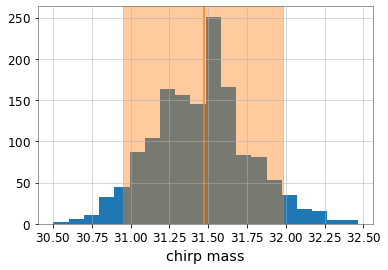

In [41]:
fig, ax = plt.subplots()
ax.hist(result_short.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C1', alpha=0.4)
ax.axvline(median, color='C1')
ax.set_xlabel("chirp mass")
plt.show()

The result object also has in-built methods to make nice plots such as corner plots. You can add the priors if you are only plotting parameters which you sampled in: for example

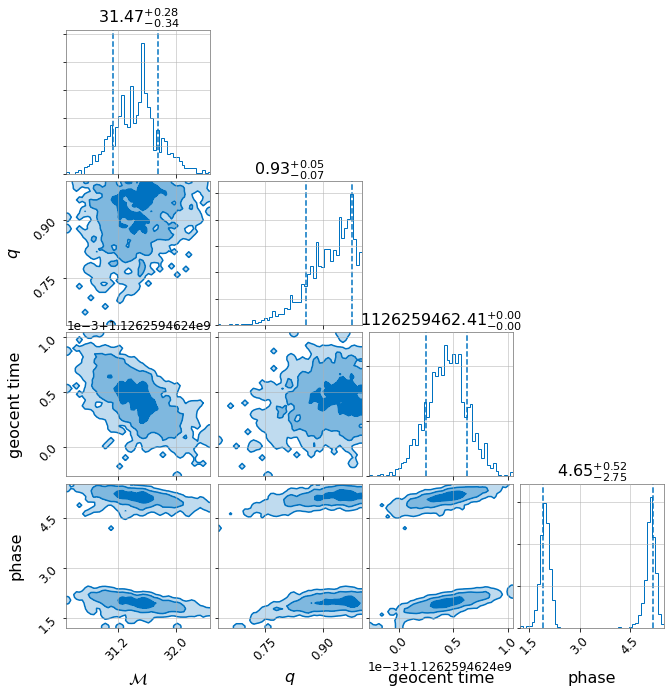

In [42]:
result_short.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time", "phase"], prior=True)

You can also plot lines indicating specific points. Here, we add the values recorded on [GWOSC](https://www.gw-openscience.org/events/GW150914/) as the final, official medians. Notably, these fall outside the bulk of the posterior uncertainty here. This is because we limited our prior. If instead we were to run the full analysis, these would agree nicely.

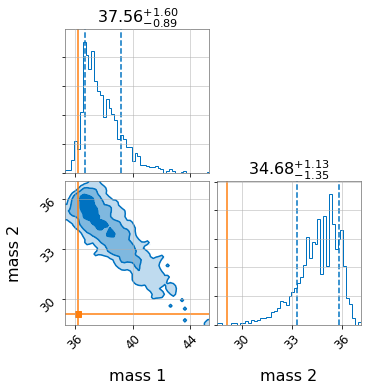

In [43]:
parameters = dict(mass_1=36.2, mass_2=29.1)
result_short.plot_corner(parameters)

In this plot we start to see the correlation between $m_1$ and $m_2$ disucssed earlier.

### Meta data
The result object also stores meta data, such as the priors

In [45]:
dir(result_short)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_prior_fixed_values_to_posterior',
 '_check_attribute_match_to_other_object',
 '_get_save_data_dictionary',
 '_kde',
 '_nburn',
 '_nested_samples',
 '_num_likelihood_evaluations',
 '_posterior',
 '_priors',
 '_safe_outdir_creation',
 '_samples',
 '_version',
 '_walkers',
 'bayesian_model_dimensionality',
 'calculate_prior_values',
 'constraint_parameter_keys',
 'covariance_matrix',
 'fixed_parameter_keys',
 'from_hdf5',
 'from_json',
 'get_all_injection_credible_levels',
 'get_injection_credible_level',
 'get_latex_labels_from_parameter_keys',
 'get_one_dimensional_median_and_error_bar',
 'get_weights_by_new_prior',


In [46]:
result_short.priors

{'chirp_mass': Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'mass_ratio': Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'phase': Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None),
 'geocent_time': Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None),
 'a_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'a_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_1': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'tilt_2': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_12': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'phi_jl': DeltaFunction(peak=0.0, name=None, latex_label=None, unit=None),
 'dec': DeltaFunction(peak=-1.2232, name=None, 

and details of the analysis itself:

In [47]:
result_short.sampler_kwargs["nlive"]

500

Finally, we can also extract the **Bayes factor** for the signal vs. Gaussian noise hypothesis testing. This quantifies the probability that the analyzed segment constains a binary black hole signal compared to it just containing Gaussian noise.

In [48]:
print("ln Bayes factor = {:.2f} +/- {:.2f}".format(
    result_short.log_bayes_factor, result_short.log_evidence_err))

ln Bayes factor = 268.10 +/- 0.12


### Other attributes of the result

In [49]:
print(result_short.log_evidence)
print(result_short.log_evidence_err)
print(result_short.log_noise_evidence)
print(result_short.log_bayes_factor)
print(result_short.log_evidence - result_short.log_noise_evidence)

-8266.46440646371
0.12130214058334522
-8534.561633624302
268.0972271605915
268.0972271605915


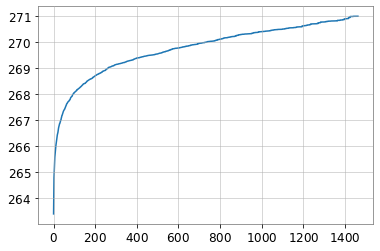

In [51]:
plt.plot(result_short.log_likelihood_evaluations);

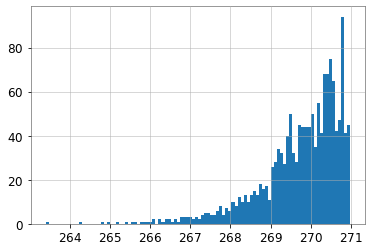

In [52]:
_, _, histo = plt.hist(result_short.log_likelihood_evaluations, bins=100)

In [53]:
print(result_short.covariance_matrix)

#print(result_short.nested_samples)
#print(result_short.samples)

[[ 9.62138721e-02  3.96227210e-03 -1.70704458e-06]
 [ 3.96227210e-03  3.73945436e-03 -4.95642627e-07]
 [-1.70704458e-06 -4.95642627e-07  2.03454432e-08]]


08:56 bilby INFO    : Plotting chirp_mass marginal distribution
08:56 bilby INFO    : Plotting chirp_mass marginal distribution


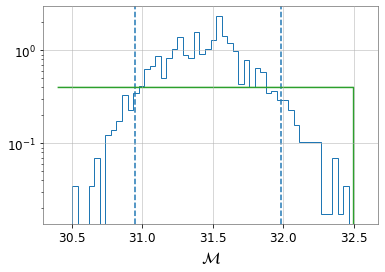

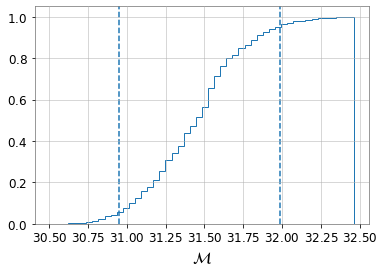

In [58]:
qty = 'chirp_mass'
#quantiles = (0.16, 0.84)
quantiles = (0.05, 0.95)
result_short.plot_single_density(qty, save=False, prior=result_short.priors[qty], quantiles=quantiles)
plt.yscale('log')
result_short.plot_single_density(qty, save=False, quantiles=quantiles, cumulative=True)
plt.yscale('linear')

In [59]:
from IPython.display import Markdown as md
md(result_short.get_one_dimensional_median_and_error_bar(qty, quantiles=quantiles).string)

${31.47}_{-0.53}^{+0.51}$

In [60]:
result_short.posterior_volume

4.664998296011057e-08